In [2]:
# Import libraries

import numpy as np
import pickle
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, regularizers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

In [3]:
# Function to load X values
def load_color_inputs():
    X_train_color = pickle.load(open('E:/training_color.pkl', "rb"))
    X_valid_color = pickle.load(open('E:/validation_color.pkl', "rb"))
    X_test_color = pickle.load(open('E:/testing_color.pkl', "rb"))
    return X_train_color, X_valid_color, X_test_color

# Function to load y values
def load_outputs():
    y_train = pickle.load(open('E:/y_training.pkl', "rb"))
    y_valid = pickle.load(open('E:/y_validation.pkl', "rb"))
    y_test = pickle.load(open('E:/y_testing.pkl', "rb"))
    return y_train, y_valid, y_test

# Function to reshape data
def reshape_input_vect(vect, size=(128, 64, 3)):
    inp_vect = []
    for i in range(vect.shape[0]):
        inp_vect.append(np.reshape(vect[i], (128, 64, 3)))
    return np.asarray(inp_vect)

# Load in X data
X_train_color, X_valid_color, X_test_color = load_color_inputs()

# Load in y data
y_train_color, y_valid_color, y_test_color = load_outputs()

# To categorical y-values [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
y_train_color = to_categorical(y_train_color, num_classes = None, dtype='float32')
y_valid_color = to_categorical(y_valid_color, num_classes = None, dtype='float32')
y_test_color = to_categorical(y_test_color, num_classes = None, dtype='float32')

In [4]:
# Shuffle data
np.random.seed(200)
X_train_color, X_valid_color, X_test_color = np.random.permutation(X_train_color), np.random.permutation(
    X_valid_color), np.random.permutation(X_test_color)
np.random.seed(200)
y_train_color, y_valid_color, y_test_color = np.random.permutation(y_train_color), np.random.permutation(
    y_valid_color), np.random.permutation(y_test_color)

# Reshape data
X_train_color, X_valid_color, X_test_color = reshape_input_vect(X_train_color), reshape_input_vect(X_valid_color), reshape_input_vect(X_test_color)

In [ ]:
# RandomSearch for hyperparameter tuning 
# Source: Keras Tuner: https://keras.io/keras_tuner/

def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(128, 64, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    
    for i in range(hp.Int('layers', 2, 4)): # Searching through for 2, 3 and 4 hidden layers
        model.add(tf.keras.layers.Dense(
            units=hp.Int('units_' + str(i), 32, 512, step=32), # Searching for optimal amount of nodes per hidden layer from 32 to 512 with step size of 32
            activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid']))) # Searching for optimal activation method
    model.add(tf.keras.layers.Dense(4, activation='softmax')) # Output layer is kept out of the for loop because that is fixed
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                     values=[1e-2, 1e-3, 1e-4])), # Learning Rate of 0.01, 0.001 and 0.0001
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy', # Objective is to maximize validation accuracy
    max_trials=10, # Trial 5 times
    executions_per_trial=3, # Each trial, try 1 different model
    )

tuner.search_space_summary()

tuner.search(X_train_color,y_train_color, 
             epochs=10, 
             validation_data=(X_valid_color,y_valid_color))

tuner.results_summary()

In [8]:
# Best output from RandomSearch

# Trial summary
# Hyperparameters:
# layers: 3
# units_0: 480
# act_0: sigmoid
# units_1: 224
# act_1: relu
# learning_rate: 0.001
# units_2: 32
# act_2: relu
# Score: 0.9901041587193807

### CNN MODEL

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(128, 64, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(480, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(224, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

optimizer_adam = Adam(learning_rate=0.001)

model.summary()

model.compile(optimizer=optimizer_adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train_color, y_train_color, epochs=20, verbose=1, validation_data=(X_valid_color, y_valid_color))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 60, 32)       2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 62, 30, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 28, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 30, 14, 64)       

In [9]:
# Accuracy on validation set
[loss, acc] = model.evaluate(X_valid_color, y_valid_color, verbose=1)
print("Accuracy:" + str(acc))

20/20 [==============================] - 0s 10ms/step - loss: 0.0739 - accuracy: 0.9844
Accuracy:0.984375


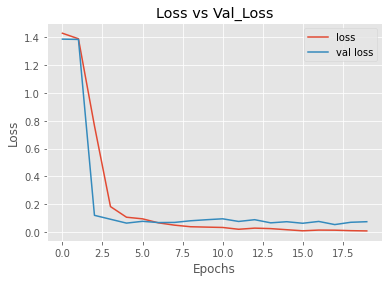

In [10]:
#Show train vs validation loss

plt.style.use('ggplot')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
# Accuracy on test set
model.evaluate(X_test_color, y_test_color)

20/20 [==============================] - 0s 7ms/step - loss: 0.0687 - accuracy: 0.9906


[0.0687379464507103, 0.9906250238418579]

In [12]:
# Save model
model.save('CNN_2_color_model',save_format='h5')

In [5]:
# Load model
model = tf.keras.models.load_model('CNN_2_color_model')

In [6]:
# Accuracy on test set
model.evaluate(X_test_color, y_test_color)

20/20 [==============================] - 4s 7ms/step - loss: 0.0687 - accuracy: 0.9906


[0.0687379464507103, 0.9906250238418579]

In [8]:
# Predict the values from the validation dataset and convert predictions classes to one hot vectors
categories = ['Left to right', "Pull", "Push", "Right to left"]
y_pred = np.argmax(model.predict(X_test_color), axis=-1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test_color, axis=-1)

# Print Classification report
print(classification_report(y_true, y_pred, target_names=categories, digits=4))

20/20 [==============================] - 0s 5ms/step
               precision    recall  f1-score   support

Left to right     0.9753    0.9875    0.9814       160
         Pull     0.9876    0.9938    0.9907       160
         Push     1.0000    0.9812    0.9905       160
Right to left     1.0000    1.0000    1.0000       160

     accuracy                         0.9906       640
    macro avg     0.9907    0.9906    0.9906       640
 weighted avg     0.9907    0.9906    0.9906       640



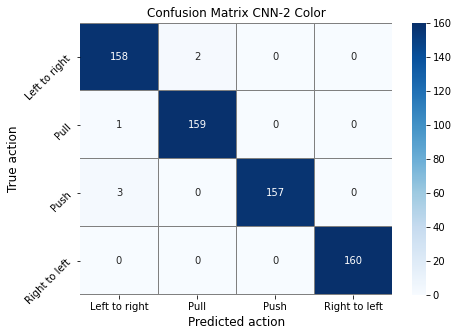

In [9]:
# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred) 
# Plot the confusion matrix
categories = ['Left to right', "Pull", "Push", "Right to left"]
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="grey", fmt= 'g',ax=ax, xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted action", fontsize=12)
plt.ylabel("True action", fontsize=12)
plt.title("Confusion Matrix CNN-2 Color")
locs, labels = plt.yticks()
plt.setp(labels, rotation=45)
plt.show()